In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from jax.scipy.stats import multivariate_normal
from jax.experimental import optimizers
from jax.experimental import stax
from jax.lax import stop_gradient
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from functools import partial
from dm_control import suite
import jax.numpy as jnp
import numpy as np
import jax
import ipdb

method_jit = partial(jax.jit, static_argnums=(0,))  # jit that works with class methods

# notes
- **std options:** if std learned, save stds along with actions and use to compute action probs // if stds annealed per batch, have modify

**todo**
- make sure `ppo.policy.params` are changing over learning... if not, add as args to act and evaluate

In [24]:
class Env():
    ''' dm_control environment wrapper '''
    def __init__(self, domain, task):
        self.env = suite.load(domain, task)
        time_step = self.env.reset()
        self.action_dim = self.env.action_spec().shape[0]
        self.state_dim = len(self.process_time_step(time_step)[0])
        self.action_min = self.env.action_spec().minimum
        self.action_max = self.env.action_spec().maximum
        self.max_steps = self.env._step_limit
    
    def step(self, action):
        timestep = self.env.step(action)
        return self.process_time_step(timestep)
        
    def reset(self):
        return self.process_time_step(self.env.reset())[0]  # only return state
        
    @staticmethod
    def process_time_step(time_step):
        """ Convert 'dm_env._environment.TimeStep' to (state, reward, done) """
        state = np.hstack([v for v in time_step.observation.values()])
        return state, time_step.reward, time_step.last()
    
    @property
    def step_count(self):
        return self.env._step_count


def mlp(key, input_dim, output_dim, hidden_layers=(64,32)):
    ''' make multilayer perceptron '''
    layers = []
    for hl in hidden_layers:
        layers += [stax.Dense(hl), stax.Tanh]
    layers.append(stax.Dense(output_dim))
    
    init_fun, apply_fun = stax.serial(*layers)
    params = init_fun(key, (-1, input_dim))[1]
    
    return apply_fun, params

In [25]:
class ActorCritic():
    ''' todo: make super class, subclasses for discrete, cont, shared, not shared params, etc '''
    
    def __init__(self, key, state_dim, action_dim, std=1,
                 actor_hlayers=(32,16), critic_hlayers=(32,16)):
        ''' todo: should std be object property? '''
        
        self.state_dim  = state_dim
        self.action_dim = action_dim
        self.std = std
        
        keys = jax.random.split(key, num=2)
        self.actor, actor_params   = mlp(keys[0], state_dim, action_dim, actor_hlayers)
        self.critic, critic_params = mlp(keys[1], state_dim, 1, critic_hlayers)
        self.params = {'actor': actor_params, 'critic': critic_params}
    
    @method_jit
    def act(self, key, actor_params, state: np.array):        
        action_mean = self.actor(actor_params, state)
        cov = jnp.diag(jnp.repeat(self.std, self.action_dim))
        
        action = jax.random.multivariate_normal(key, action_mean, cov)
        action_prob = multivariate_normal.pdf(action, action_mean, cov)
        
        return stop_gradient(action), stop_gradient(action_prob)
    
    @method_jit
    def evaluate(self, critic_params, states: np.array):
        ''' todo: add entropy output '''
        return stop_gradient(self.critic(critic_params, states)[:,0])  # first dim is batch
    
    @method_jit
    def get_action_probs(self, actor_params, states: np.array, actions: np.array):
        action_means = self.actor(actor_params, states)
        cov = jnp.diag(jnp.repeat(self.std, self.action_dim))
        action_probs = multivariate_normal.pdf(actions, action_means, cov)
        
        return action_probs

In [26]:
class PPO():
    
    def __init__(self, policy, eps_clip=.2, v_coeff=1, gamma=.99,
                 gae_param=.95, learning_rate=1e-2, loss_weight=1,
                 K_epochs=4, minibatch_size=64):
        self.reset_memory()
        self.policy = policy
        self.eps_clip = eps_clip
        self.v_coeff = v_coeff
        self.gamma = gamma
        self.gae_param = gae_param
        self.loss_weight = loss_weight
        self.K_epochs = K_epochs
        self.minibatch_size = minibatch_size
        
        opt_init, opt_update, get_params = optimizers.adam(learning_rate)
        opt_state = opt_init(self.policy.params)
        self.optimizer = {'state': opt_state, 'update': opt_update, 'get_params': get_params}
    
    
    @method_jit
    def loss(self, params, actions: np.array, states: np.array, old_action_probs: np.array,
             returns: np.array, advantages: np.array):
        ''' todo: importance sampling? '''
        
        values       = self.policy.evaluate(params['critic'], states)
        action_probs = self.policy.get_action_probs(params['actor'], states, actions)
        ratio        = action_probs / stop_gradient(old_action_probs)
        
        loss1 = advantages * ratio
        loss2 = advantages * jnp.clip(ratio, 1-self.eps_clip, 1+self.eps_clip)
        actor_loss = -jnp.minimum(loss1, loss2)
        
        critic_loss = .5 * jnp.power((returns - values), 2)
        
        return jnp.mean(actor_loss + self.loss_weight * critic_loss)
        
    
    dloss = method_jit(jax.grad(loss, argnums=1))
    
    
#     @method_jit
    def update(self, key):
        ''' todo: where to compute advantages? // normalize reward option? '''
        
        returns, advantages = self.get_returns_and_advantages(self.policy.params['critic'],
                                                              self.memory['states'],
                                                              self.memory['is_terminals'],
                                                              self.memory['rewards']
                                                             )
        n_minibatches = np.ceil(len(returns) / self.minibatch_size).astype('int')
        keys = jax.random.split(key, num=K_epochs)  # np.array indexing is much faster
        
        for i in range(self.K_epochs):
        
            shuffled_inds = jax.random.shuffle(keys[i], jnp.arange(len(returns)))
        
            for j in range(n_minibatches):
                start_ind = j * self.minibatch_size
                inds = shuffled_inds[start_ind : start_ind+self.minibatch_size]

                grads = self.dloss(self.policy.params,
                                   jnp.array(self.memory['actions'])[inds],
                                   jnp.array(self.memory['states'])[inds],
                                   jnp.array(self.memory['action_probs'])[inds],
                                   jnp.array(returns)[inds],
                                   jnp.array(advantages)[inds]
                                  )
                
                # todo: is it right to reset optimizer count for each batch? or just the count rollover?
                update_count = i * K_epochs + j
                self.optimizer['state'] = self.optimizer['update'](update_count, grads, self.optimizer['state'])
                self.policy.params = self.optimizer['get_params'](self.optimizer['state'])
        
        self.reset_memory()
    
    
    def get_returns_and_advantages(self, critic_params, states: np.array,
                                   is_terminals: np.array, rewards: np.array):
        
        values = self.policy.evaluate(critic_params, np.array(states))  # split into batches?
        last_return, last_advantage = 0, 0
        returns, advantages = [], []
        
        for reward, value, is_terminal in list(zip(rewards, values, is_terminals))[::-1]:
            if is_terminal:
                last_return = 0
                last_advantage = 0
            else:
                last_return = reward + self.gamma * last_return
                returns.insert(0, last_return)
                
                td_error = last_return - value
                last_advantage = td_error + self.gamma * self.gae_param * last_advantage
                advantages.insert(0, last_advantage)
        
        return returns, advantages
    
    
    def add_memory(self, state: np.array, action: np.array, reward: np.array, 
                   action_prob: np.array, is_terminal: np.array):
        ''' todo: refactor to fewer lines '''
        self.memory['states'].append(state)
        self.memory['actions'].append(np.asarray(action))
        self.memory['rewards'].append(reward)
        self.memory['action_probs'].append(np.asarray(action_prob))  # todo: asarray necessary?
        self.memory['is_terminals'].append(is_terminal)
        
    
    def reset_memory(self):
        self.memory = {'states': [],
                       'actions': [],
                       'rewards': [],
                       'action_probs': [],
                       'is_terminals': []}
    
    @property
    def n_memories(self):
        return len(self.memory['states'])

/home/richard/anaconda3/envs/dm_control/lib/python3.7/site-packages/jax/_src/random.py:478: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'episode reward')

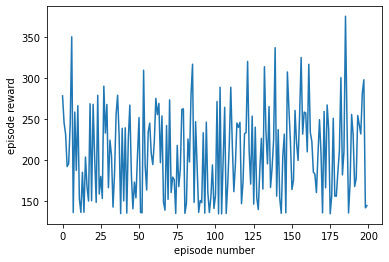

In [28]:
# settings (temp)
domain='cartpole'
task='balance'
batch_size=1024 * 20  # 1000 steps per episode
max_episodes = 200
seed = 0
hidden_layers = (24,48)
K_epochs = 4
minibatch_size = int(batch_size/8)
learning_rate = 3e-4

# todo: does terminate early? if not, switch from lengths to total reward!

key = jax.random.PRNGKey(seed)
env = Env(domain, task)
state = env.reset()  # todo: random seed stuff!

policy = ActorCritic(key, env.state_dim, env.action_dim,
                     actor_hlayers=hidden_layers, critic_hlayers=hidden_layers)

ppo = PPO(policy, K_epochs=K_epochs, minibatch_size=minibatch_size, learning_rate=learning_rate)
params_init = ppo.policy.params.copy()  # temp

update_count = 0
keys = np.array(jax.random.split(key, num=(max_episodes * env.max_steps)))
total_rewards = []

with trange(max_episodes, desc='Episode') as t:
    for i in t:
        state = env.reset()
        rewards = []
        done = False
        
        while not done:
            action, action_prob = ppo.policy.act(keys[i], ppo.policy.params['actor'], state)
            state_next, reward, done = env.step(action)
            ppo.add_memory(state, action, reward, action_prob, done)
            state = state_next
            rewards.append(reward)
                
            if ppo.n_memories==batch_size:
                ppo.update(key)
                update_count += 1
        
        total_rewards.append(sum(rewards))
        t.set_postfix(total_reward=total_rewards[-1], n_memories=ppo.n_memories, n_updates=update_count)


# plot
plt.plot(total_rewards)
plt.xlabel('episode number')
plt.ylabel('episode reward')

# tests

In [40]:
ppo.policy.params['actor']
# params_init['actor']

[(DeviceArray([[-1.59226164e-01,  2.67246008e-01,  1.67197496e-01,
                -3.28479171e-01,  4.73437533e-02, -1.88753843e-01,
                -1.61882341e-01,  1.44369245e-01,  3.04927647e-01,
                 4.87117618e-02,  5.46110988e-01, -5.51769733e-02,
                 1.19824514e-01, -1.11358695e-01,  2.41230816e-01,
                 2.47519583e-01,  9.25094187e-02, -2.78572321e-01,
                 3.43789726e-01, -5.34611881e-01,  4.61789131e-01,
                -1.74363226e-01, -2.15926781e-01,  2.93597132e-01],
               [ 1.36740999e-02,  5.62866986e-01,  3.06676894e-01,
                 2.13156328e-01, -1.03208236e-01,  2.91939080e-01,
                 1.48919672e-01, -3.07899378e-02,  8.32463801e-02,
                 3.86974961e-01,  2.81702548e-01, -4.52254973e-02,
                -5.35276311e-04, -5.53834736e-01,  2.64523625e-01,
                -1.03452161e-01, -1.28573805e-01, -3.53843182e-01,
                -2.84008563e-01,  1.10098138e-01, -1.13073535

In [ ]:
'''
train(env, max_episodes, batch_size, minibatch_size, 
      K, eps_clip, gamma, lr, lambda, gamma)
      
      make env
      make ppo
      while epochs<epochs:
          get exp, add to memory
          if nmemories==batch_size:
              update
              epochs += 1
          
'''